In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

# Load and Preprocess Data

In [2]:
data = pd.read_csv('Breast_Cancer.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [3]:
columns_to_drop = ['Race', 'Marital Status', '6th Stage', 'A Stage', 
                   'Regional Node Examined', 'Survival Months']
data = data.drop(columns=columns_to_drop, axis=1)

data = data.dropna()

In [4]:
data.rename(columns=lambda x: x.strip(), inplace=True)

In [5]:
categorical_columns = ['T Stage', 'N Stage', 'differentiate', 'Grade', 'Estrogen Status', 'Progesterone Status']

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

numerical_columns = ['Age', 'Tumor Size', 'Reginol Node Positive']

data.head()

,Age,T Stage,N Stage,differentiate,Grade,Tumor Size,Estrogen Status,Progesterone Status,Reginol Node Positive,Status
0,68,0,0,1,3,4,1,1,1,Alive
1,50,1,1,0,2,35,1,1,5,Alive
2,58,2,2,0,2,63,1,1,7,Alive
3,58,0,0,1,3,18,1,1,1,Alive
4,47,1,0,1,3,41,1,1,1,Alive


In [6]:
X = data.drop(['Status'], axis=1)
y = data['Status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Processed Data Shape:", data.shape)
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Processed Data Shape: (4024, 10)
Training Data Shape: (3219, 9)
Testing Data Shape: (805, 9)


# Implementing the Single-Layer Perceptron (SLP)

In [7]:
def initialize_weights(input_size):
    weights = np.random.randn(input_size) * 0.01  
    bias = 0.0
    return weights, bias

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward_pass(X, weights, bias):
    z = np.dot(X, weights) + bias  
    predictions = sigmoid(z)       
    return predictions

def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

def backpropagation(X, y_true, y_pred, weights, bias, learning_rate):
    m = X.shape[0] 
    dz = y_pred - y_true
    dw = np.dot(X.T, dz) / m  
    db = np.sum(dz) / m      
    
    weights -= learning_rate * dw
    bias -= learning_rate * db
    
    return weights, bias

In [8]:
def train_perceptron(X_train, y_train, epochs=1000, learning_rate=0.01):
    input_size = X_train.shape[1]
    weights, bias = initialize_weights(input_size)
    
    for epoch in range(epochs):

        y_pred = forward_pass(X_train, weights, bias)
        
        loss = binary_cross_entropy(y_train, y_pred)
        
        
        weights, bias = backpropagation(X_train, y_train, y_pred, weights, bias, learning_rate)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    return weights, bias

In [9]:
y_train = y_train.replace({"Alive": 1, "Dead": 0})
y_test = y_test.replace({"Alive": 1, "Dead": 0})
weights, bias = train_perceptron(
    X_train.to_numpy().astype(float),  
    y_train.to_numpy().astype(float),
    epochs=1000, 
    learning_rate=0.01
)

def predict(X, weights, bias):
    y_pred = forward_pass(X, weights, bias)
    return (y_pred >= 0.5).astype(int)

def evaluate_model(X_test, y_test, weights, bias):
    y_pred = predict(X_test, weights, bias)
    accuracy = np.mean(y_pred == y_test) * 100
    return accuracy

weights, bias = train_perceptron(X_train.to_numpy(), y_train.to_numpy(), epochs=1000, learning_rate=0.01)

accuracy = evaluate_model(X_test.to_numpy(), y_test.to_numpy(), weights, bias)
print(f"Model Accuracy: {accuracy:.2f}%")

Epoch 0, Loss: 0.6436
Epoch 100, Loss: 0.9684
Epoch 200, Loss: 2.6789
Epoch 300, Loss: 0.9522
Epoch 400, Loss: 0.4481
Epoch 500, Loss: 2.2008
Epoch 600, Loss: 0.4612
Epoch 700, Loss: 1.5602
Epoch 800, Loss: 1.4656
Epoch 900, Loss: 0.4469
Epoch 0, Loss: 1.0154
Epoch 100, Loss: 1.0328
Epoch 200, Loss: 0.8357
Epoch 300, Loss: 0.4586
Epoch 400, Loss: 1.6254
Epoch 500, Loss: 0.6764
Epoch 600, Loss: 0.8581
Epoch 700, Loss: 2.4174
Epoch 800, Loss: 2.2342
Epoch 900, Loss: 0.5227
Model Accuracy: 84.97%


In [10]:
def evaluate_model_with_metrics(X_test, y_test, weights, bias):
    y_pred = predict(X_test, weights, bias)  # Predict the test set
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = np.mean(y_pred == y_test) * 100
    
    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

evaluate_model_with_metrics(X_test.to_numpy(), y_test.to_numpy(), weights, bias)

Model Accuracy: 84.97%
Precision: 0.85
Recall: 1.00
F1-Score: 0.92


In [11]:
def initialize_weights(input_size):
    weights = np.zeros(input_size)
    bias = 0
    return weights, bias

# Forward pass
def forward_pass(X, weights, bias):
    return 1 / (1 + np.exp(-(np.dot(X, weights) + bias)))  # Sigmoid function


def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15 
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


def backpropagation(X, y_true, y_pred, weights, bias, learning_rate):
    m = len(y_true)
    dw = (1 / m) * np.dot(X.T, (y_pred - y_true)) 
    db = (1 / m) * np.sum(y_pred - y_true)  
    weights -= learning_rate * dw
    bias -= learning_rate * db
    return weights, bias


def train_perceptron_with_loss(X_train, y_train, epochs=1000, learning_rate=0.01):
    input_size = X_train.shape[1]
    weights, bias = initialize_weights(input_size)
    loss_history = [] 
    
    for epoch in range(epochs):

        y_pred = forward_pass(X_train, weights, bias)
        

        
        loss = binary_cross_entropy(y_train, y_pred)
        loss_history.append(loss)
        
        
        weights, bias = backpropagation(X_train, y_train, y_pred, weights, bias, learning_rate)
        

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    return weights, bias, loss_history

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 2.1571
Epoch 200, Loss: 2.2237
Epoch 300, Loss: 1.9266
Epoch 400, Loss: 1.0156
Epoch 500, Loss: 2.5952
Epoch 600, Loss: 1.6380
Epoch 700, Loss: 2.5652
Epoch 800, Loss: 0.5670
Epoch 900, Loss: 0.4681


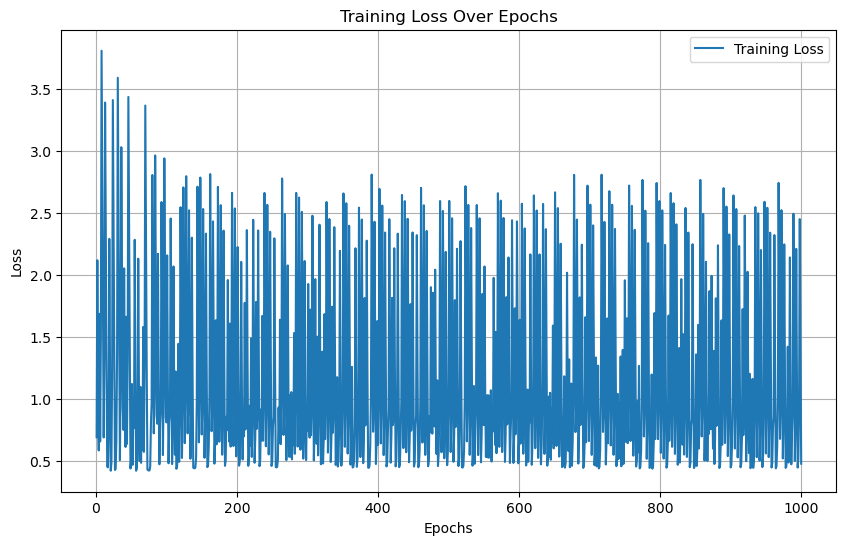

In [12]:
weights, bias, loss_history = train_perceptron_with_loss(X_train.to_numpy(), y_train.to_numpy(), epochs=1000, learning_rate=0.01)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Visualizing a Single Layer Perceptron

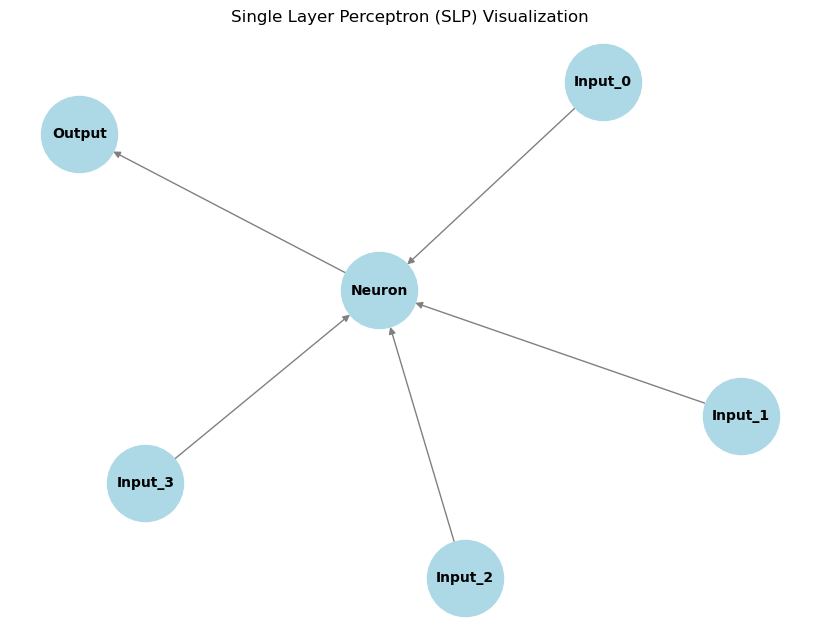

In [13]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()


G.add_nodes_from([f'Input_{i}' for i in range(4)] + ['Neuron', 'Output'])


G.add_edges_from([(f'Input_{i}', 'Neuron') for i in range(4)] + [('Neuron', 'Output')])

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold')


plt.title("Single Layer Perceptron (SLP) Visualization")
plt.show()

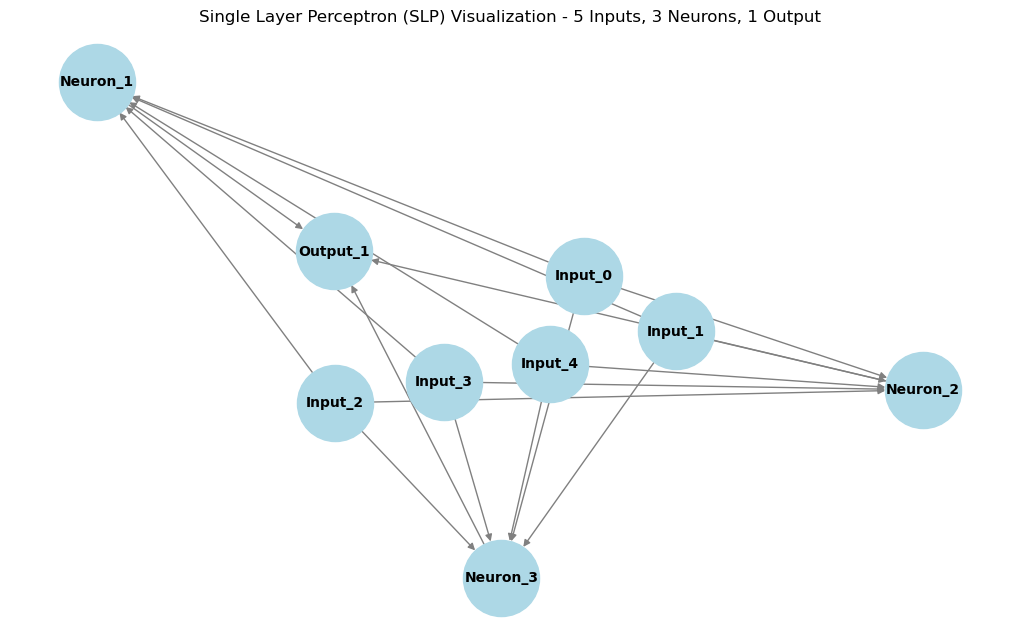

In [14]:
num_inputs = 5
num_neurons = 3 
num_outputs = 1

G = nx.DiGraph()

G.add_nodes_from([f'Input_{i}' for i in range(num_inputs)] + [f'Neuron_{i+1}' for i in range(num_neurons)] + [f'Output_{i+1}' for i in range(num_outputs)])

for i in range(num_inputs):
    for j in range(num_neurons):
        G.add_edge(f'Input_{i}', f'Neuron_{j+1}') 

for j in range(num_neurons):
    for k in range(num_outputs):
        G.add_edge(f'Neuron_{j+1}', f'Output_{k+1}')  

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold')

plt.title(f"Single Layer Perceptron (SLP) Visualization - {num_inputs} Inputs, {num_neurons} Neurons, {num_outputs} Output")
plt.show()

# Hyperparameter Tuning


Training with learning rate: 0.1
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 5.2898
Epoch 200, Loss: 5.2608
Epoch 300, Loss: 4.7324
Epoch 400, Loss: 5.3981
Epoch 500, Loss: 8.8626
Epoch 600, Loss: 5.2580
Epoch 700, Loss: 4.7364
Epoch 800, Loss: 6.8710
Epoch 900, Loss: 5.2898

Training with learning rate: 0.01
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 2.1571
Epoch 200, Loss: 2.2237
Epoch 300, Loss: 1.9266
Epoch 400, Loss: 1.0156
Epoch 500, Loss: 2.5952
Epoch 600, Loss: 1.6380
Epoch 700, Loss: 2.5652
Epoch 800, Loss: 0.5670
Epoch 900, Loss: 0.4681

Training with learning rate: 0.001
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.4235
Epoch 200, Loss: 0.4183
Epoch 300, Loss: 0.4161
Epoch 400, Loss: 0.4151
Epoch 500, Loss: 0.4146
Epoch 600, Loss: 0.4143
Epoch 700, Loss: 0.4140
Epoch 800, Loss: 0.4138
Epoch 900, Loss: 0.4136


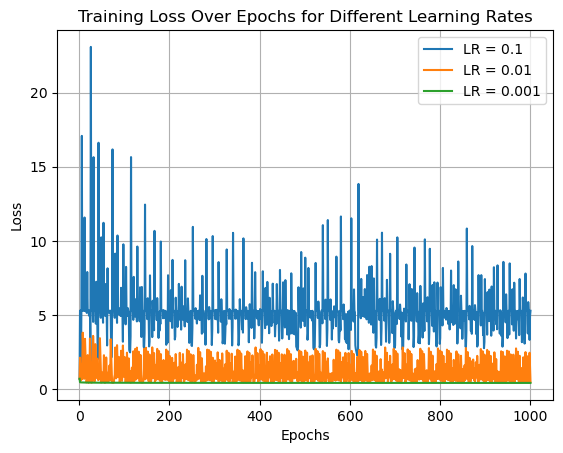

In [15]:
learning_rates = [0.1, 0.01, 0.001]  # Different learning rates to test

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    weights, bias, loss_history = train_perceptron_with_loss(X_train.to_numpy(), y_train.to_numpy(), epochs=1000, learning_rate=lr)
    plt.plot(range(1, 1001), loss_history, label=f"LR = {lr}")
    
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()

In [16]:
epochs = 1000
patience = 50
best_loss = np.inf
epochs_without_improvement = 0

for epoch in range(epochs):
    
    y_pred = forward_pass(X_train, weights, bias)  
    loss = binary_cross_entropy(y_train, y_pred)  
    
    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0 
    else:
        epochs_without_improvement += 1  
        
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

Early stopping at epoch 50


# Feature Scaling

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Explore Advanced Models (MLP)

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)
accuracy_mlp = np.mean(y_pred_mlp == y_test) * 100
print(f"MLP Model Accuracy: {accuracy_mlp:.2f}%")

MLP Model Accuracy: 82.61%


# Cross-Validation

In [20]:
scores = cross_val_score(MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000), X_train_scaled, y_train, cv=5)

print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}%")

Cross-validation scores: [0.82763975 0.83540373 0.82453416 0.83850932 0.83048212]
Mean accuracy: 0.83%
